<a href="https://colab.research.google.com/github/spch88/my_project/blob/main/%D0%92%D0%BE%D1%81%D1%81%D1%82%D0%B0%D0%BD%D0%BE%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание

Создайте автокодировщик, удаляющий черные квадраты в случайных областях изображений.

Алгоритм действий:
1. Возьмите базу картинок Mnist.
2. На картинках в случайных местах сделайте чёрные квадраты размера 8 на 8.
3. Создайте и обучите автокодировщик восстанавливать оригинальные изображения из "зашумленных" квадратом изображений.
4. Добейтесь MSE < 0.0070 на тестовой выборке

## Импорт библиотек

In [ ]:
# Отображение
import matplotlib.pyplot as plt

# Для работы с тензорами
import numpy as np 

# Класс создания модели
from tensorflow.keras.models import Model

# Для загрузки данных
from tensorflow.keras.datasets import mnist

# Необходимые слои
from tensorflow.keras.layers import Input, Conv2DTranspose, MaxPooling2D, Conv2D, BatchNormalization

# Оптимизатор
from tensorflow.keras.optimizers import Adam

## Данные

In [ ]:
# Загрузка данных
(X_train, y_train), (X_test, y_test) = mnist.load_data() 

In [ ]:
# Нормировка данных
X_train = X_train.astype('float32')/255.
X_test = X_test.astype('float32')/255.

In [ ]:
# Изменение формы под удобную для Keras
X_train = X_train.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

Решение:

In [ ]:
# Создание "зашумленных" изображений
x_train = X_train.copy()
x_test = X_test.copy()

for i in range(len(x_train)):                              
  ind_x = np.random.randint(0, 20)
  ind_y = np.random.randint(0, 20)
  x_train[i, ind_x:ind_x + 8, ind_y:ind_y + 8] = 0

for i in range(len(x_test)):                              
  ind_x = np.random.randint(0, 20)
  ind_y = np.random.randint(0, 20)
  x_test[i, ind_x:ind_x + 8, ind_y:ind_y + 8] = 0  

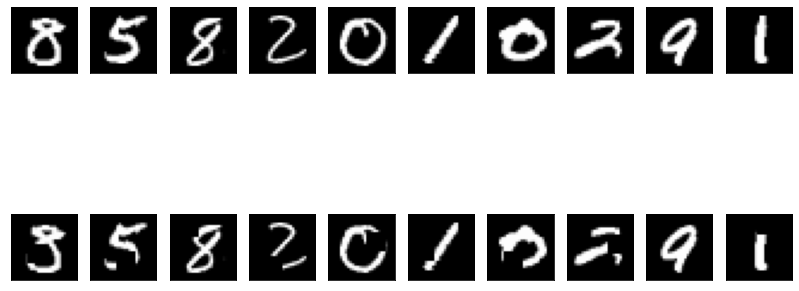

In [ ]:
# Сравним визуально исходные и "зашумленные" изображения

plt.figure(figsize=(14, 7)) 

for i in range(10):                              
  index = np.random.randint(0, len(X_train))  

# исходные изображения
  ax = plt.subplot(2, 10, i + 1)               
  plt.imshow(X_train[index].squeeze(), cmap='gray')
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False) 

# "зашумленные" изображения
  ax = plt.subplot(2, 10, i + 11)           
  plt.imshow(x_train[index].squeeze(), cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
# Сервисные функции

# Модель на основе свёрточного автокодировщика
def create_model(in_shape):
    # Энкодер
    img_input = Input(in_shape)

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) 
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x)

    z = MaxPooling2D()(x)
        
    # Декодер
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z)
    x = BatchNormalization()(x) 

    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 

    outputs = Conv2D(in_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(inputs=img_input, outputs=outputs) 

    # Компиляция НС
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse') 

    return model 


# Функция вывода нескольких изображений для сравнения
def plot_images(x_data, pred, n=7): 

    plt.figure(figsize=(14, 7))                     

    for i in range(1, n + 1):                              
        index = np.random.randint(0, pred.shape[0]) 

# Изображение с индексом index из набора x_data
        ax = plt.subplot(2, n, i)               
        plt.imshow(x_data[index].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False) 
        ax.get_yaxis().set_visible(False) 

# Изображение с тем же индексом из предсказания автокодировщика
        ax = plt.subplot(2, n, i + n)           
        plt.imshow(pred[index].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()  

In [ ]:
# Создание модели

model = create_model(X_train.shape[1:])
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_86 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_93 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_87 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_94 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 14, 14, 32)       0  

Epoch 1/15
469/469 [==============================] - 11s 21ms/step - loss: 0.0615 - val_loss: 0.0387
Epoch 2/15
469/469 [==============================] - 10s 21ms/step - loss: 0.0189 - val_loss: 0.0152
Epoch 3/15
469/469 [==============================] - 10s 21ms/step - loss: 0.0138 - val_loss: 0.0122
Epoch 4/15
469/469 [==============================] - 10s 20ms/step - loss: 0.0114 - val_loss: 0.0104
Epoch 5/15
469/469 [==============================] - 10s 20ms/step - loss: 0.0099 - val_loss: 0.0092
Epoch 6/15
469/469 [==============================] - 9s 20ms/step - loss: 0.0088 - val_loss: 0.0083
Epoch 7/15
469/469 [==============================] - 10s 21ms/step - loss: 0.0081 - val_loss: 0.0077
Epoch 8/15
469/469 [==============================] - 10s 20ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 9/15
469/469 [==============================] - 10s 20ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 10/15
469/469 [==============================] - 10s 21ms/step - loss: 0.0067

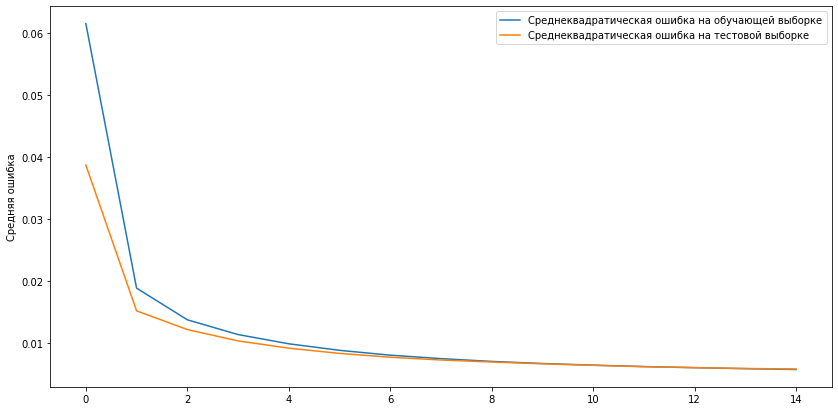

In [ ]:
# Обучение модели автокодировщика (на входе "зашумленные" и исходные данные)

history = model.fit(x_train, X_train,
                       epochs=15,
                       batch_size=128,
                       validation_data = (x_test, X_test))

# Вывод графиков процесса обучения
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Среднеквадратическая ошибка на обучающей выборке')
plt.plot(history.history['val_loss'], 
         label='Среднеквадратическая ошибка на тестовой выборке')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

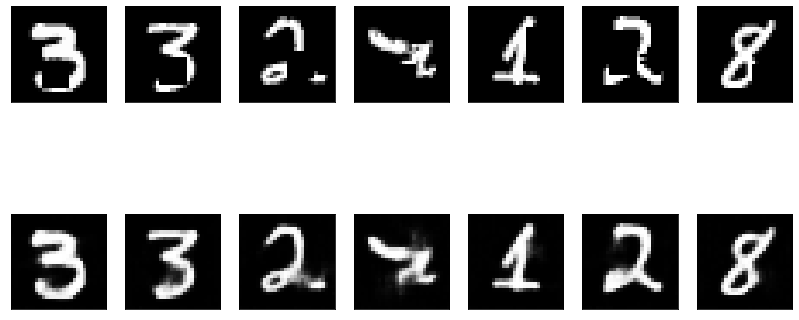

In [ ]:
# Получение предсказания на тестовой выборке
pred_test = model.predict(x_test)

# Сравнение исходных и восстановленных изображений из тестовой выборки
plot_images(x_test, pred_test)